# Data Preprocessing, Imputation, and Unsupervised Learning Techniques

# (25%) Perform data imputation using K-Nearest Neighbors.

In [1]:
import pandas as pd, numpy as np, folium, seaborn as sns, matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans


In [2]:
# Load data
df = pd.read_csv("2014_to_2024_gan_data_working.csv")
df.columns = df.columns.str.lower()


## § Task: 1.1 Impute the data using K-Nearest Neighbor imputer in SciKit-Learn.

In [4]:
# KNN
df = df.drop_duplicates()
df = df[(df["sqmreading"] == -1) | df["sqmreading"].between(17,23)]
num = ["latitude","longitude","elevation(m)","limitingmag","cloudcoverpct","sqmreading"]
df[num] = df[num].apply(pd.to_numeric, errors="coerce")


## § Task: 1.2 Provide the updated statistics for the completed dataset which now includes original and imputed SQM values.

In [5]:
# Reported mean, median and standard deviation of the new imputed data
imp = KNNImputer(n_neighbors=5)
dfi = pd.DataFrame(imp.fit_transform(df[num]), columns=num)
df["sqmreading_filled"] = dfi["sqmreading"]; df["was_imputed"] = df["sqmreading"] == -1


## § Task: BONUS: Implement your K-Nearest Neighbor imputation solution with only the NearestNeighbors algorithm of SciKit-Learn.


In [6]:
from sklearn.neighbors import NearestNeighbors

known = df[df["sqmreading"].between(17,23)]
unknown = df[df["sqmreading"] == -1]

if len(unknown) and len(known) >= 5:
    nn = NearestNeighbors(n_neighbors=5).fit(known[["latitude","longitude"]])
    idxs = nn.kneighbors(unknown[["latitude","longitude"]], return_distance=False)
    df.loc[unknown.index, "sqmreading_filled"] = [known.iloc[i]["sqmreading"].median() for i in idxs]
    print(f"Filled {len(unknown)} missing SQM readings using 5-Nearest Neighbors median.")
else:
    print("Skipped because not enough data.")

Filled 152529 missing SQM readings using 5-Nearest Neighbors median.


In [7]:
# BONUS: NearestNeighbors Algorithm of SciKit-Learn
from sklearn.neighbors import NearestNeighbors
known = df[df["sqmreading"].between(17,23)].copy()
unknown = df[df["sqmreading"] == -1].copy()
if len(unknown) > 0 and len(known) >= 5:
    nbrs = NearestNeighbors(n_neighbors=5).fit(known[["latitude","longitude"]])
    dist, idxs = nbrs.kneighbors(unknown[["latitude","longitude"]])
    unknown["sqm_nn"] = [np.median(known.iloc[i]["sqmreading"].values) for i in idxs]
    df.loc[unknown.index, "sqmreading_filled"] = unknown["sqm_nn"]
    print("Bonus imputer: filled", len(unknown), "rows using 5-NN median by lat/lon")
else:
    print("Bonus imputer skipped (no missing or too few neighbors).")

Bonus imputer: filled 152529 rows using 5-NN median by lat/lon


In [8]:
print("Mean:", df["sqmreading_filled"].mean(), 
      "Median:", df["sqmreading_filled"].median(),
      "Std:", df["sqmreading_filled"].std())


Mean: 17.3405044886673 Median: 19.22 Std: 6.1328273114135365


## § Task: 1.3 Use Folium to plot the data for the bounding box and constraints given.

In [9]:
# Latitude > 45.79 and < 45.92 ,Longitude > 15 and < 16,SQMReading above 20, Plot the original SQM Reading with red pins, 
# plot the imputed data with blue pins, Include the Latitude, Longitude and SQMReading in the popup of the pin.

m = folium.Map(location=[45.85,15.5], zoom_start=11)
sub = df[df["latitude"].between(45.79,45.92) & df["longitude"].between(15,16) & (df["sqmreading_filled"]>20)]
for _,r in sub.iterrows():
    folium.CircleMarker([r.latitude,r.longitude],radius=4,
        color="blue" if r.was_imputed else "red",
        fill=True,fill_color="blue" if r.was_imputed else "red").add_to(m)
m

# (50%) Cluster data from GaN light pollution data features using K-Means.

## § Task: 2.1 Convert CloudCoverPct and LimitingMag to binary features, eliminate all remaining non-binary fea￾tures except SQMReading.

In [10]:
# K-Means Clustering 
df = df[(df["sqmreading_filled"].between(17,23)) & (df["limitingmag"]>0)].copy()
for v in [0.0,0.25,0.5,0.75]: df[f"ccp_{v}"]=(df["cloudcoverpct"].round(2)==v).astype(int)
df["limitingmag_int"]=df["limitingmag"].astype(int).clip(0,7)
lm=pd.get_dummies(df["limitingmag_int"],prefix="lm").reindex(columns=[f"lm_{i}" for i in range(8)],fill_value=0)
lm


,lm_0,lm_1,lm_2,lm_3,lm_4,lm_5,lm_6,lm_7
0,0,False,True,False,False,False,False,False
1,0,False,True,False,False,False,False,False
2,0,False,True,False,False,False,False,False
3,0,False,False,True,False,False,False,False
4,0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...
202520,0,False,False,False,True,False,False,False
202521,0,False,False,False,False,True,False,False
202522,0,False,False,False,False,False,True,False
202523,0,False,False,False,False,True,False,False


In [11]:
cols_const=[c for c in df if c.startswith("const_")]
cols_loc=[c for c in df if c.startswith("loc_")]
final=pd.concat([df[["sqmreading_filled"]+cols_const+cols_loc+[f"ccp_{v}" for v in [0.0,0.25,0.5,0.75]]],lm],axis=1)
final.rename(columns={"sqmreading_filled":"SQM Reading"},inplace=True)
final.to_csv("gan_cluster_final.csv",index=False)
final


,SQM Reading,const_bootes,const_canis major,const_crux,const_cygnus,const_gemini,const_grus,const_hercules,const_leo,const_none,...,ccp_0.5,ccp_0.75,lm_0,lm_1,lm_2,lm_3,lm_4,lm_5,lm_6,lm_7
0,19.70,False,False,False,False,False,False,True,False,0,...,0,0,0,False,True,False,False,False,False,False
1,19.70,False,False,False,False,False,False,True,False,0,...,0,0,0,False,True,False,False,False,False,False
2,19.70,False,False,False,False,False,False,True,False,0,...,0,0,0,False,True,False,False,False,False,False
3,19.70,False,False,False,False,False,False,True,False,0,...,0,0,0,False,False,True,False,False,False,False
4,19.70,False,False,False,False,False,False,True,False,0,...,0,0,0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202520,18.67,False,False,False,False,False,False,False,False,0,...,0,0,0,False,False,False,True,False,False,False
202521,17.83,False,False,False,False,False,False,False,False,0,...,0,0,0,False,False,False,False,True,False,False
202522,20.82,False,False,False,True,False,False,False,False,0,...,0,0,0,False,False,False,False,False,True,False
202523,20.24,False,False,False,False,False,False,False,False,0,...,0,0,0,False,False,False,False,True,False,False


## § Task: 2.2 Use sklearn.cluster.kmeans to cluster the data in gan_cluster_final.csv.

In [12]:
X=final.drop(columns=["SQM Reading"]).values
km=KMeans(n_clusters=12,n_init=1,random_state=0)
final["cluster"]=km.fit_predict(X)
final.to_csv("gan_cluster_final_assigned.csv",index=False)
km


,n_clusters,12
,init,'k-means++'
,n_init,1
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


## § Task: 2.3 Use groupby() to group by all the clusters.

In [13]:
agg = pd.read_csv("gan_cluster_final_agg.csv")

# (25%) Visualize cluster data from GaN light pollution clustering.

## § Task: Use the Seaborn library to display a heatmap of the data in gan_cluster_final_agg.csv.

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
# Load the aggregated cluster file
agg = pd.read_csv("gan_cluster_final_agg.csv")


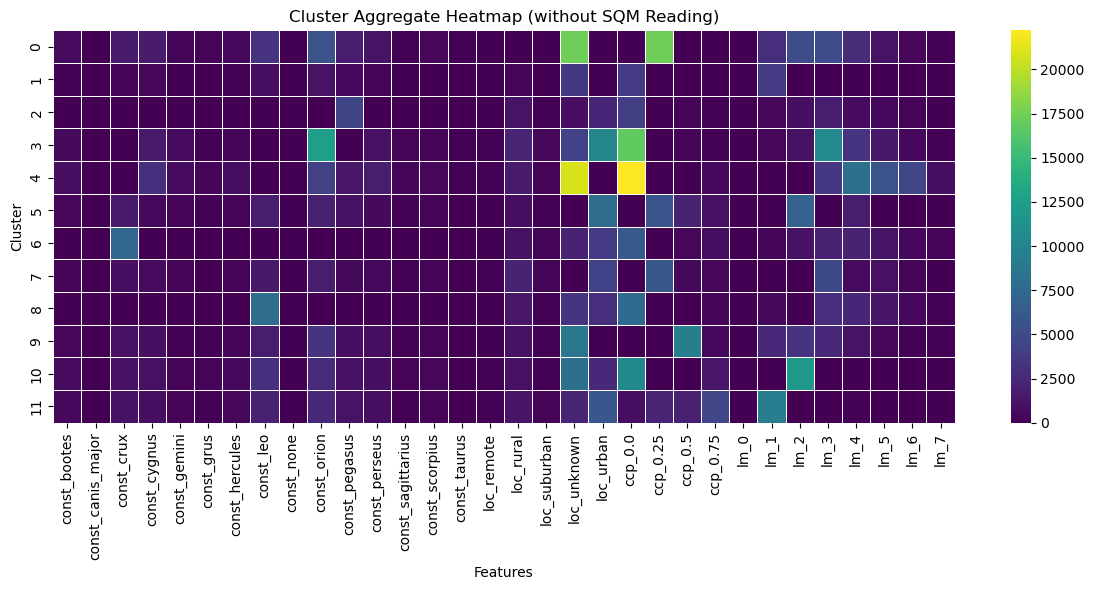

In [16]:
# Remove 'SQM Reading' column to prevent overscaling
if "SQM Reading" in agg.columns:
    agg = agg.drop(columns=["SQM Reading"])

agg = agg.set_index("cluster")

plt.figure(figsize=(12,6))
sns.heatmap(agg, cmap="viridis", linewidths=0.5)
plt.title("Cluster Aggregate Heatmap (without SQM Reading)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()